# Try to cluster samples to get local ancestry using Kohonen's SOMs
- https://www.polarmicrobes.org/tutorial-self-organizing-maps-in-r/
- https://www.shanelynn.ie/self-organising-maps-for-customer-segmentation-using-r/

In [1]:
library(kohonen)
library(Matrix )
library(irlba  )



In [41]:
source("/frazer01/projects/CEGS/analysis/hla_type_1kgp/script/functions_hla_type.R")


In [3]:
outfolder = paste(getwd(), "pipeline", "local_ancestry", sep = "/")

dir.create(outfolder                                , showWarnings = FALSE)
dir.create(paste(outfolder, "ld_pruning", sep = "/"), showWarnings = FALSE)
dir.create(paste(outfolder, "tmp"       , sep = "/"), showWarnings = FALSE)


# Find independent variants
- https://www.cog-genomics.org/plink/2.0/ld
- --indep-pairwise <window size>['kb'] [step size (variant ct)] <phased-r^2 threshold>

In [54]:
prefix  = paste(outfolder, "ld_pruning", "snps", sep = "/")
command = paste("plink2_64",
                "--indep-pairwise", 500, 1000, 0.2,
                "--vcf", vcf_snps,
                "--out", prefix
               )

system(command)

# Test by region
- https://medium.com/principal-component-analysis-on-a-high-dimensional/https-medium-com-pcasparsematrix-545d18efff0a

## define regions

In [63]:
region_size       = 1000000
region_offset     =  500000
regions           = data.frame(chrom = 6, rfrom = seq(from = (from), to = (to - 1), by = region_offset), rto = 0)
regions$rto       = regions$rfrom + region_size
regions           = regions %>% filter(rfrom < to & rto <= to)
regions$coord     = paste0(regions$chrom, ":", regions$rfrom, "-", regions$rto)
regions$rid       = paste (regions$chrom,      regions$rfrom,      regions$rto, sep = "_")
rownames(regions) = regions$coord

In [69]:
regions           = data.frame(chrom = chrom, rfrom = from, rto = to, coord = coord, rid = paste(chrom, from, to, sep = "_"))
rownames(regions) = regions$coord

In [71]:
divide_phase = function(gts, allele)
{
    gts           = apply(as.matrix(gts), 1:2, function(x){unlist(strsplit(x, "\\|"))[[allele]]})
    colnames(gts) = paste(colnames(gts), allele, sep = ":")
    class   (gts) = "numeric"
    
    return(gts)
}

divide_gts = function(gts)
{
    ids           = colnames(gts)
    vars          = rownames(gts)
    gt1           = divide_phase(gts, 1)
    gt2           = divide_phase(gts, 2)
    gts           = cbind(gt1, gt2)
    rownames(gts) = vars
    gts           = as(as.matrix(gts), "sparseMatrix")
    
    return(gts)
}

get_gts = function(region, regions, vcf, snp_file)
{
    rid     = regions[ region, "rid"]
    command = paste("bcftools", "query",
                    "-H",
                    "-r", regions[ region, "coord"],
                    "-i", "'INFO/AF[0] > 0.05 & INFO/AF[0] < 0.95'",
                    "-f", "'%CHROM\\t%POS\\t%REF\\t%ALT\\t%ID[\\t%GT]\\n'",
                    vcf,
                    "|more",
                    ""
                    )
    
    rsids            = readLines(snp_file)
    indata           = fread(cmd = command, sep = "\t", header = TRUE, data.table = FALSE)
    ids              = unlist(lapply(colnames(indata)[6:ncol(indata)], function(x){unlist(strsplit(sub(":GT", "", x), "]"))[[2]]}))
    colnames(indata) = c("chrom", "pos", "ref", "alt", "rsid", ids)
    indata           = indata[ indata$rsid %in% rsids, ]
    indata$id        = paste(indata$chrom, indata$pos, indata$ref, indata$alt, sep = "_")
    rownames(indata) = indata$id
    var_info         = indata[, c("chrom", "pos", "ref", "alt", "rsid", "id")]
    gts              = indata[, ids]
    gts              = divide_gts(gts)
    subject_ids      = data.frame(id_allele = colnames(gts), 
                              id        =            unlist(lapply(colnames(gts), function(x){unlist(strsplit(x, ":"))[[1]]})),
                              allele    = as.numeric(unlist(lapply(colnames(gts), function(x){unlist(strsplit(x, ":"))[[2]]})))
                             )
    
    return(list(info        = var_info   , 
                subject_ids = subject_ids,
                gt          = gts))
}

region = regions[1, "coord"]
indata = get_gts(region, regions, vcf_snps, paste(prefix, "prune.in", sep = "."))


bcftools query -H -r 6:25000001-34000001 -i 'INFO/AF[0] > 0.05 & INFO/AF[0] < 0.95' -f '%CHROM\t%POS\t%REF\t%ALT\t%ID[\t%GT]\n' /frazer01/projects/CEGS/analysis/hla_type_1kgp/input/vcf/mhc.vcf.gz |more 

Warning message in fread(cmd = command, sep = "\t", header = TRUE, data.table = FALSE):
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”


In [72]:

var_info    = indata[[1]]
subject_ids = indata[[2]]
gts         = indata[[3]]

set.seed(2)
#subject_ids = subject_ids[ sample(1:nrow(subject_ids), size = 500, replace = FALSE),]


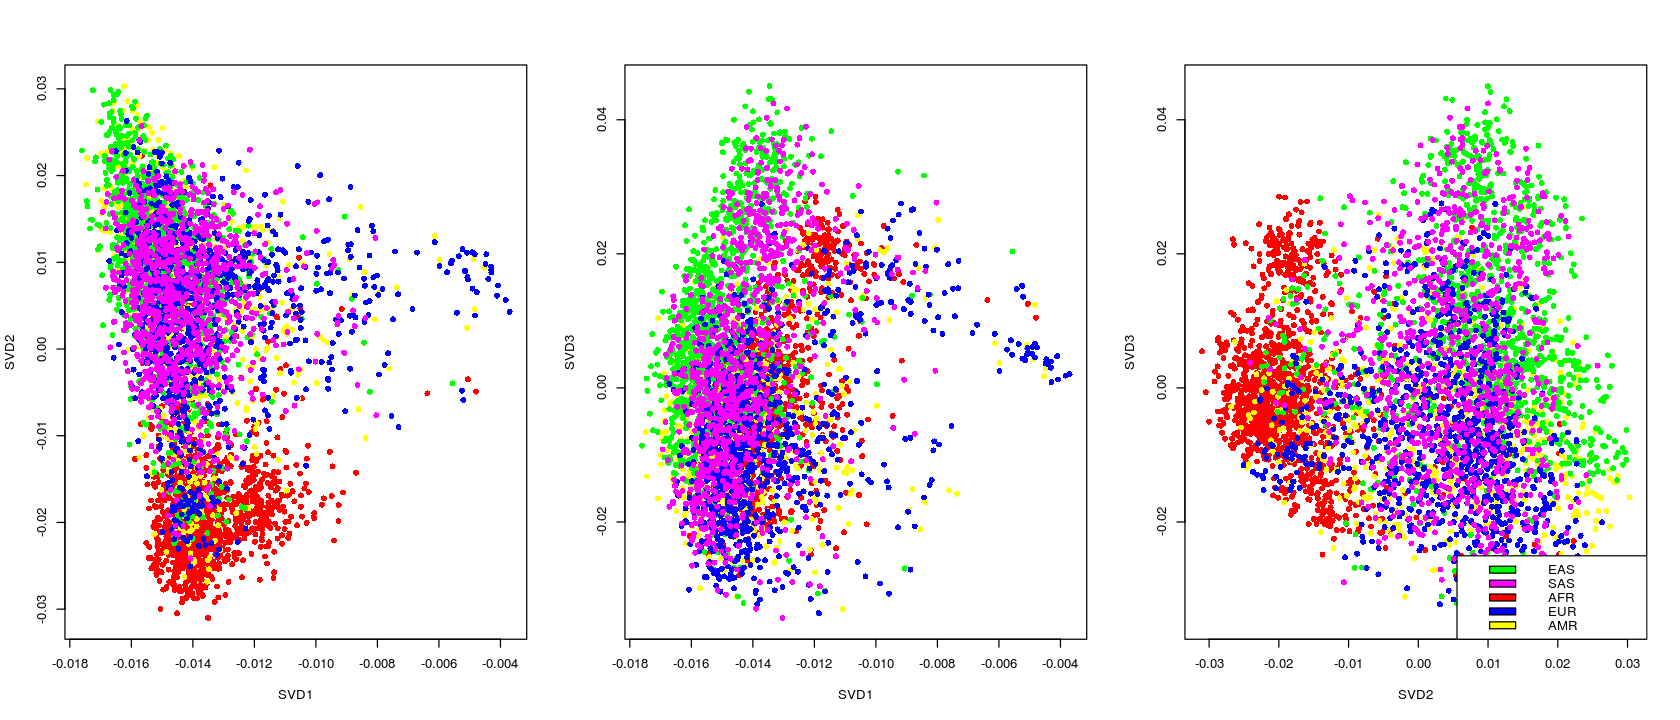

In [73]:
run_svd_irlba = function(x, subject_ids, ancestry_1kgp, superpops)
{
    x = x[, subject_ids$id_allele]
    
    set.seed(1)

    t_comp              = 50
    svd_out             = svd(scale(x, center = colMeans(x), scale = FALSE), nv = t_comp)
    rotations           = svd_out$v
    colnames(rotations) = paste0("v", 1:ncol(rotations))
    out                 = cbind(subject_ids, rotations)
    out                 = merge(out, ancestry_1kgp[, c("subject_id", "population", "super_population")], by.x = "id", by.y = "subject_id")
    out                 = merge(out, superpops    [, c("super_population", "color")])
    
    plot(out$v1, out$v2, pch = 16, col = out$color, xlab = "SVD1", ylab = "SVD2")
    plot(out$v1, out$v3, pch = 16, col = out$color, xlab = "SVD1", ylab = "SVD3")
    plot(out$v2, out$v3, pch = 16, col = out$color, xlab = "SVD2", ylab = "SVD3")
    
    legend("bottomright", legend = superpops$super_population, fill = superpops$color)
    
    return(out)
}

psize(14,6)
layout(rbind(1:3))
svd_all = run_svd_irlba(gts, subject_ids, ancestry_1kgp, superpops)


In [100]:
set.seed(1)

x                = kmeans(svd_all[,c(paste0("v", 1:50))], centers = 5)
svd_data         = svd_all
svd_data$cluster = x$cluster

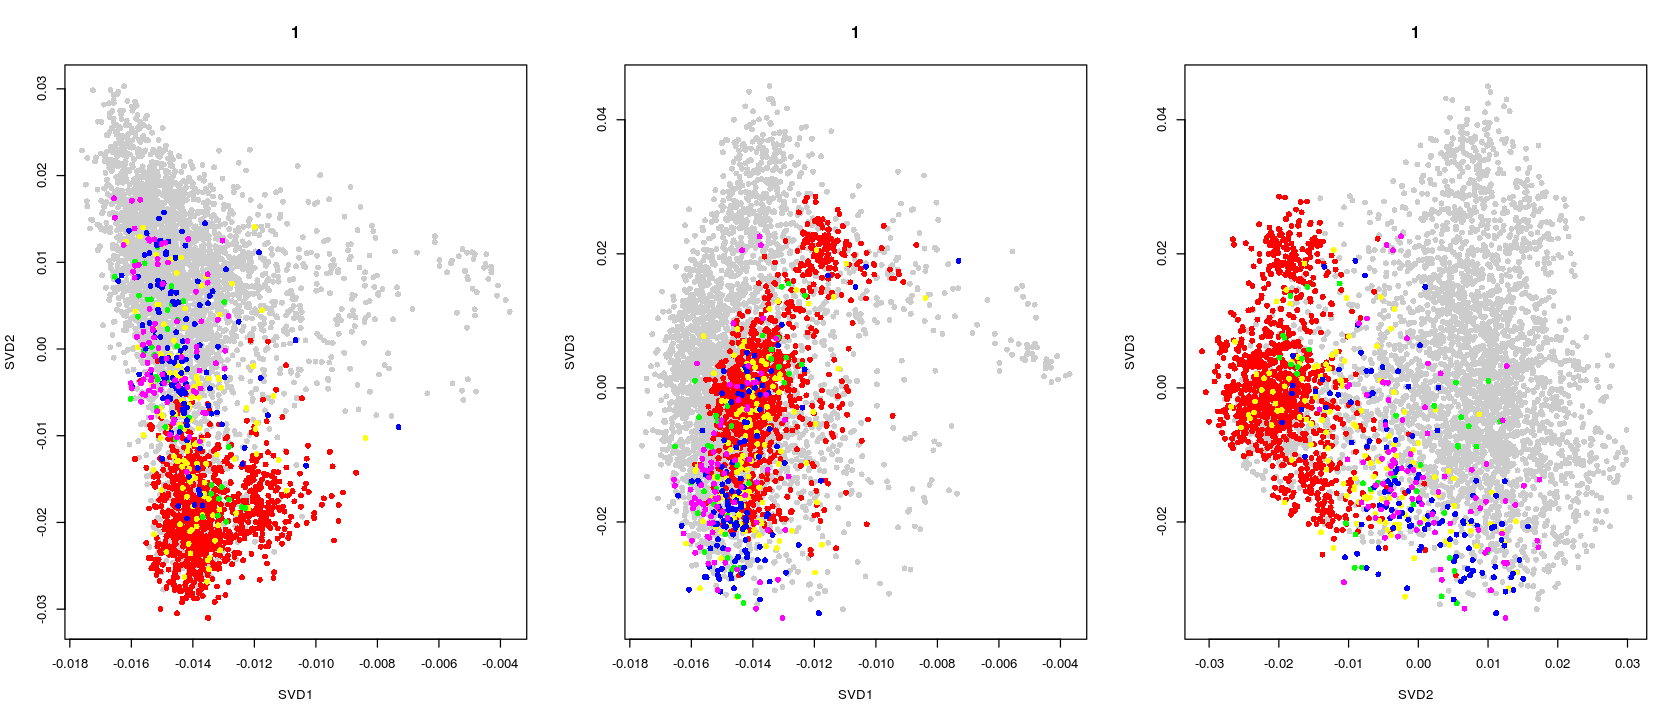

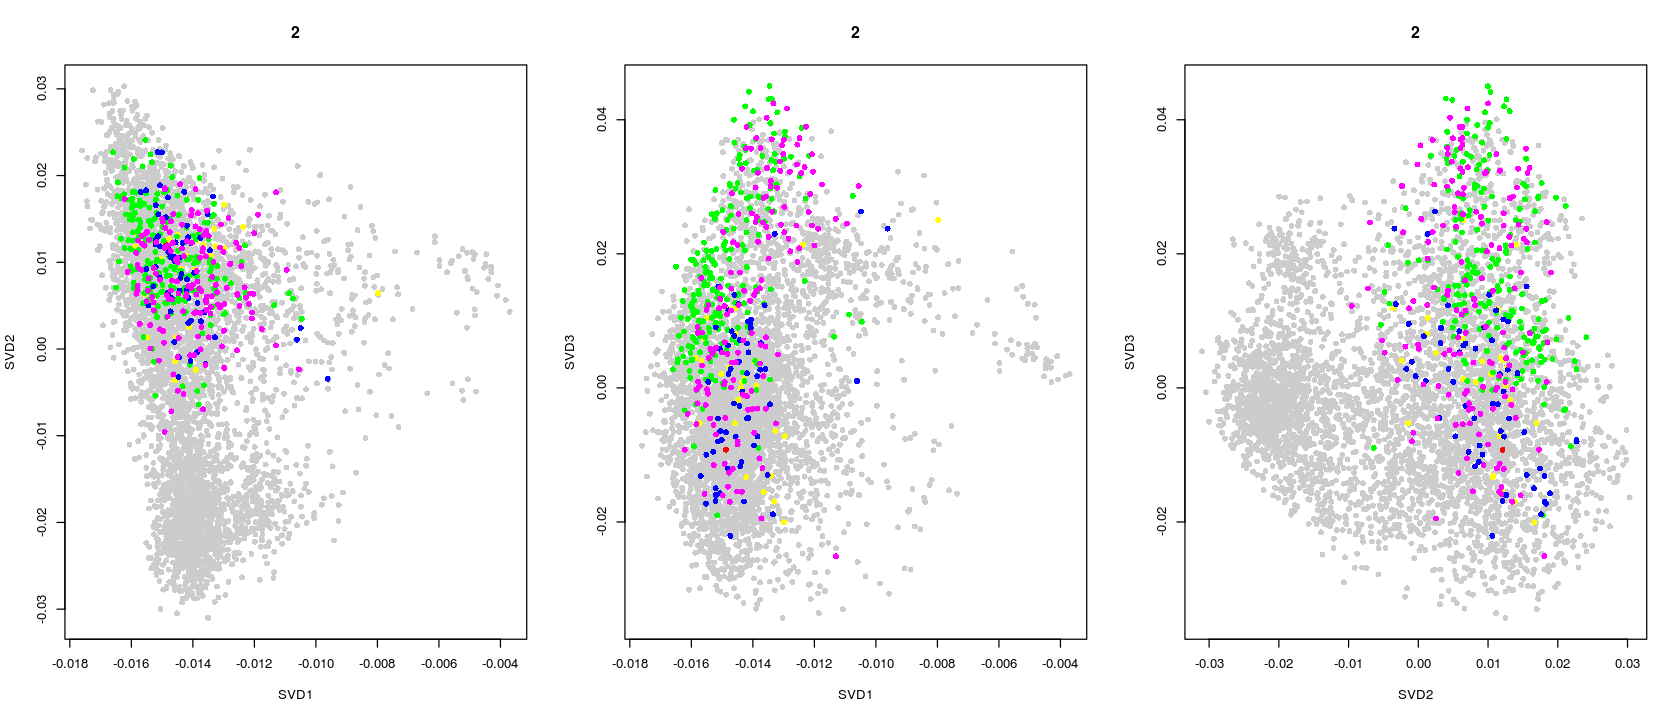

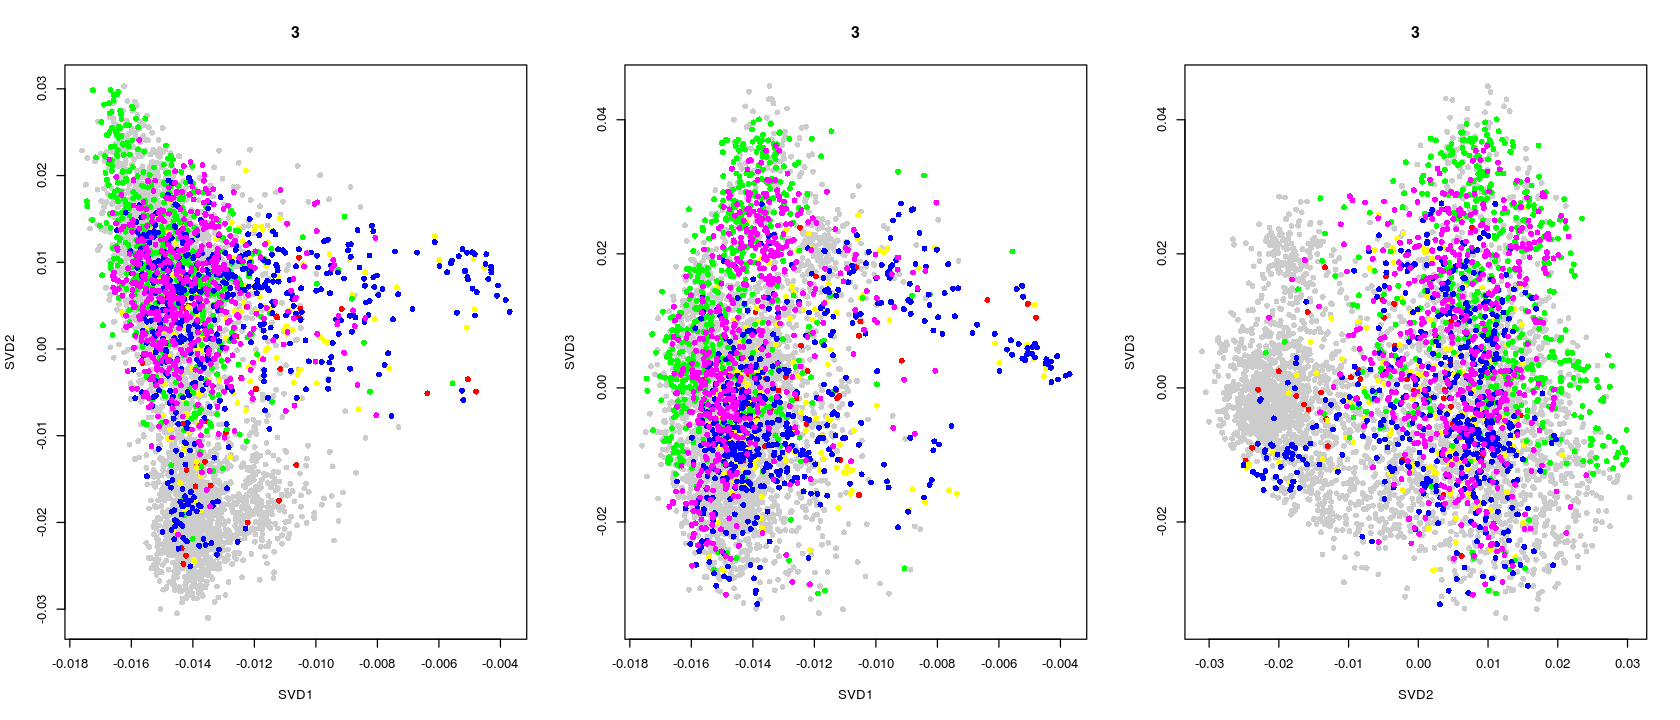

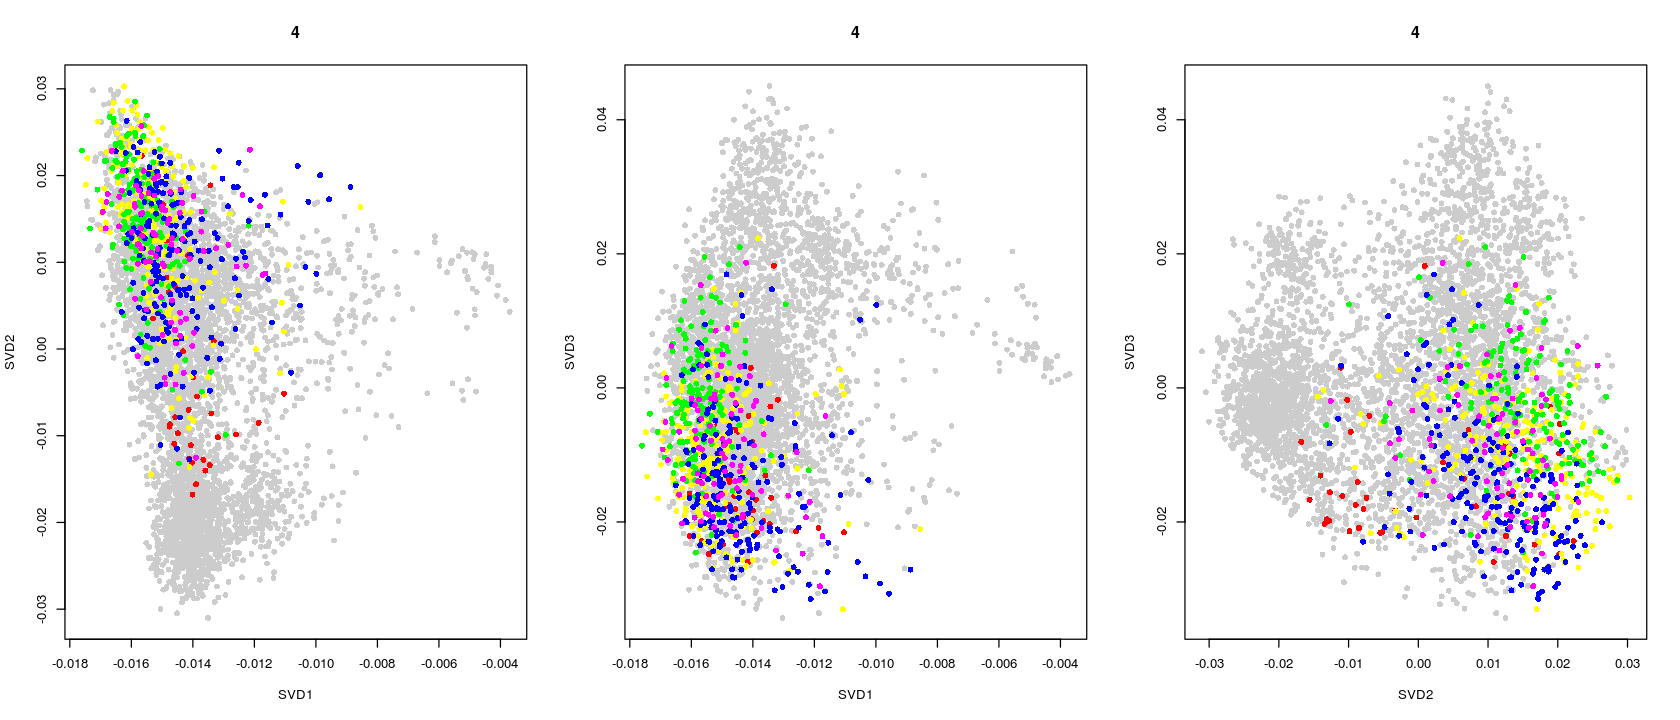

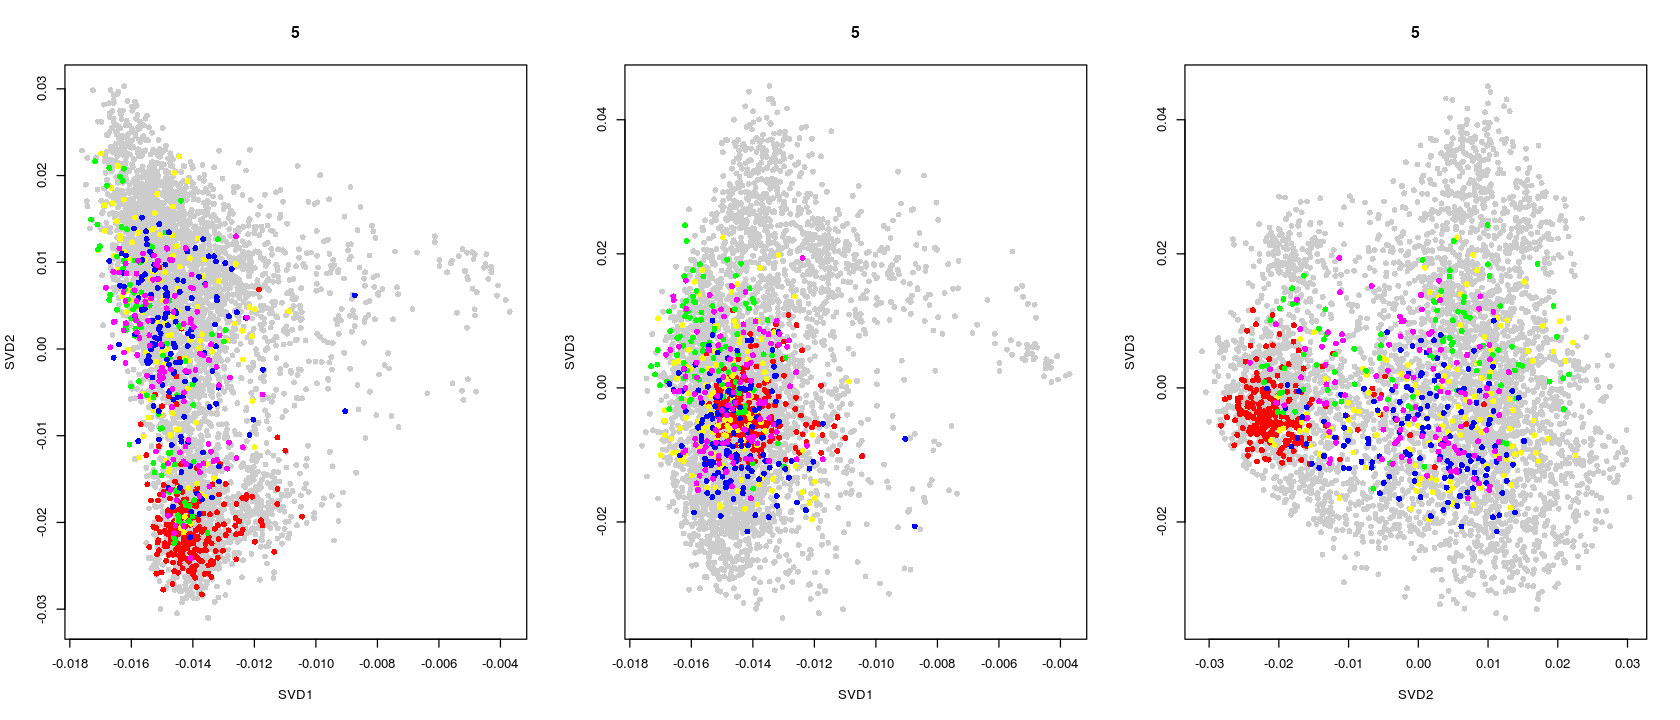

In [101]:
psize(14,6)
layout(rbind(1:3))

invisible(lapply(1:5, function(cluster)
{
    toplot = svd_data
    toplot[ toplot$cluster != cluster, "color"] = "#cccccc"
    toplot = rbind(toplot[toplot$cluster != cluster,], 
                   toplot[toplot$cluster == cluster,]
                  )
    
    plot(toplot$v1, toplot$v2, pch = 16, col = toplot$color, xlab = "SVD1", ylab = "SVD2", main = cluster)
    plot(toplot$v1, toplot$v3, pch = 16, col = toplot$color, xlab = "SVD1", ylab = "SVD3", main = cluster)
    plot(toplot$v2, toplot$v3, pch = 16, col = toplot$color, xlab = "SVD2", ylab = "SVD3", main = cluster)
}))

# SOMs

In [107]:
rownames(svd_all) = svd_all$id_allele

In [105]:
library(kohonen)
library(tempR)


In [108]:
set.seed(222)
somgrid_size = 20
g   = somgrid(xdim = somgrid_size, ydim = somgrid_size, topo = "hexagonal", toroidal = TRUE)
map = som(as.matrix(svd_all[,paste0("v", 1:50)]), grid = g, alpha = c(0.05, 0.01))

In [115]:
colors = function(n, alpha = 1)
{
    sequential_hcl(n = n, alpha = alpha, palette = "Purple-Blue", rev = TRUE)
}
options(repr.plot.width = 11, repr.plot.height = 11)
#plot(map, type = 'counts'         , palette.name = colors, keepMargins = FALSE)
#plot(map, type = 'dist.neighbours', palette.name = colors, keepMargins = FALSE)
#plot(map, type = 'codes'          , palette.name = colors, keepMargins = FALSE)
#plot(map, type = 'mapping'        , pchs = 16)


In [111]:
set.seed(222)
clusters_to_save = kmeans(x = map$codes[[1]], centers = 30, iter.max = 500, nstart = 10)
clusters         = clusters_to_save$cluster

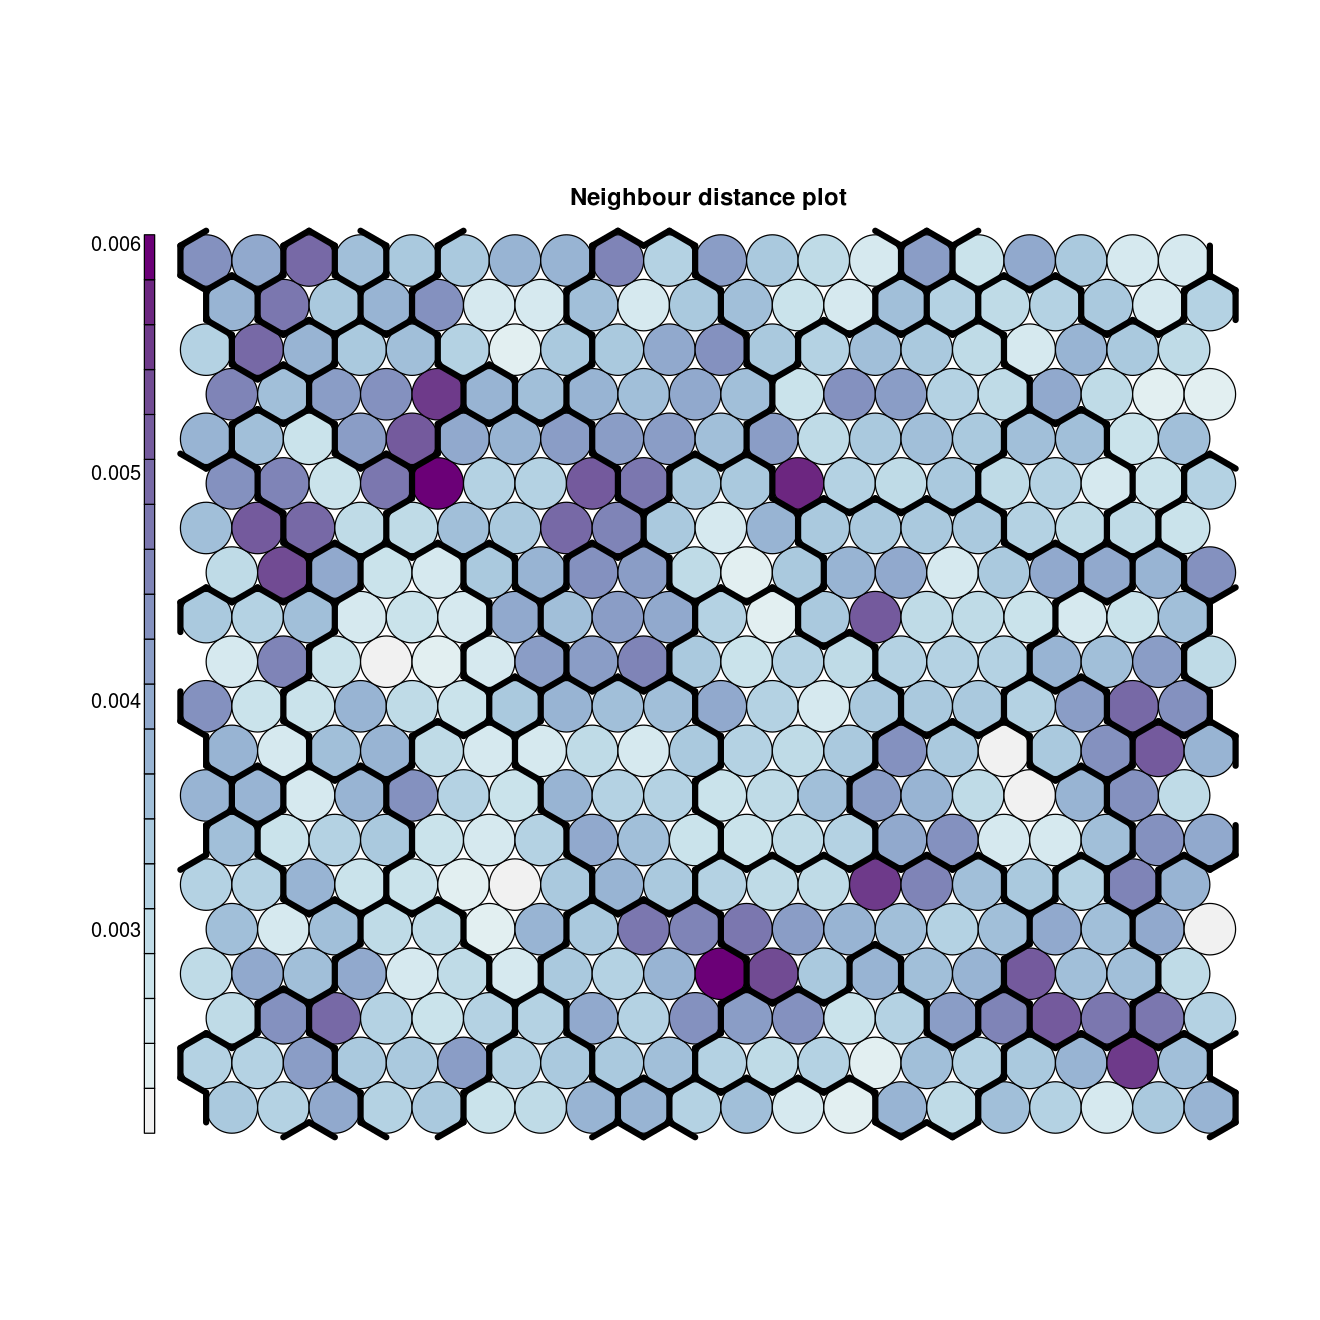

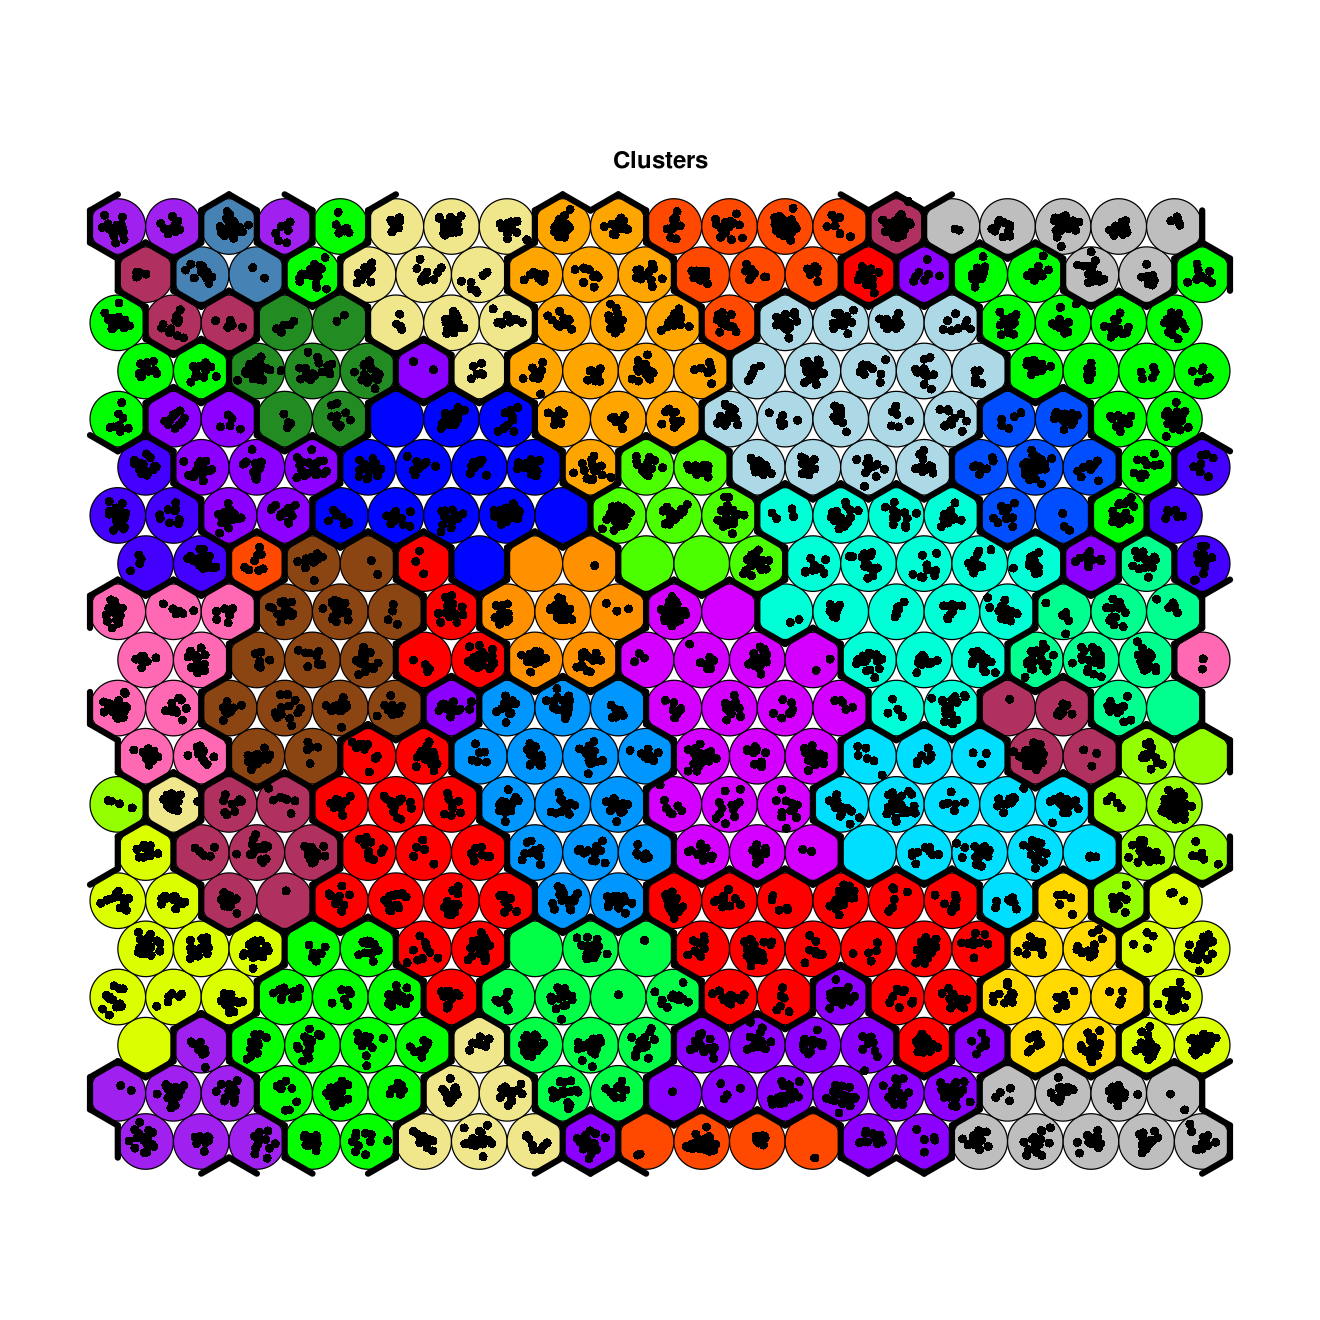

In [112]:
plotSOM = function(clusters)
{
    plot(map, type = 'dist.neighbours', palette.name = colors, pchs = 16)
    add.cluster.boundaries(map, clusters)
}

options(repr.plot.width = 11, repr.plot.height = 11)
plotSOM(clusters)

plot(map, type = "mapping", bgcol = pretty_palette(length(unique(clusters)))[clusters], main = "Clusters", pchs = 16) 
add.cluster.boundaries(map, clusters)

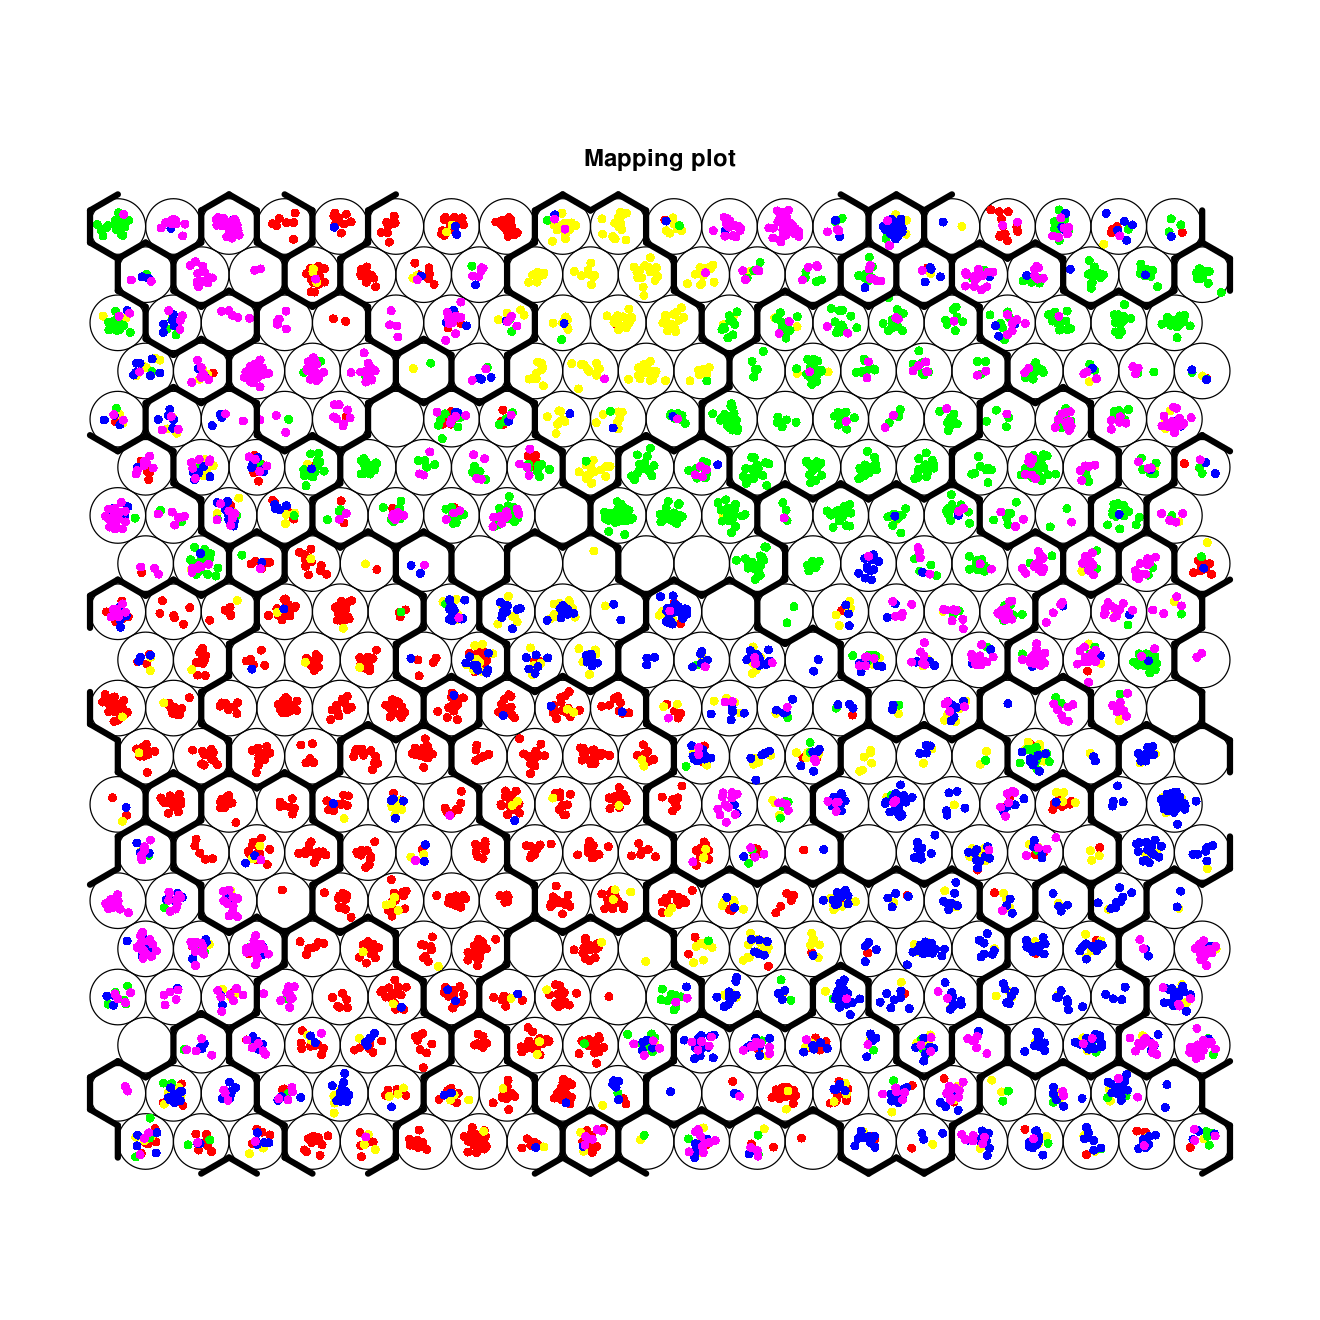

In [114]:
plot(map, type = 'mapping'        , pchs = 16, col = svd_all$color)
add.cluster.boundaries(map, clusters)

# SOMs

In [107]:
rownames(svd_all) = svd_all$id_allele

In [105]:
library(kohonen)
library(tempR)


In [119]:
set.seed(222)
somgrid_size = 20
g   = somgrid(xdim = somgrid_size, ydim = somgrid_size, topo = "hexagonal", toroidal = TRUE)
map = som(as.matrix(t(gts)), grid = g, alpha = c(0.05, 0.01))

In [120]:
colors = function(n, alpha = 1)
{
    sequential_hcl(n = n, alpha = alpha, palette = "Purple-Blue", rev = TRUE)
}
options(repr.plot.width = 11, repr.plot.height = 11)
#plot(map, type = 'counts'         , palette.name = colors, keepMargins = FALSE)
#plot(map, type = 'dist.neighbours', palette.name = colors, keepMargins = FALSE)
#plot(map, type = 'codes'          , palette.name = colors, keepMargins = FALSE)
#plot(map, type = 'mapping'        , pchs = 16)


In [121]:
set.seed(222)
clusters_to_save = kmeans(x = map$codes[[1]], centers = 30, iter.max = 500, nstart = 10)
clusters         = clusters_to_save$cluster

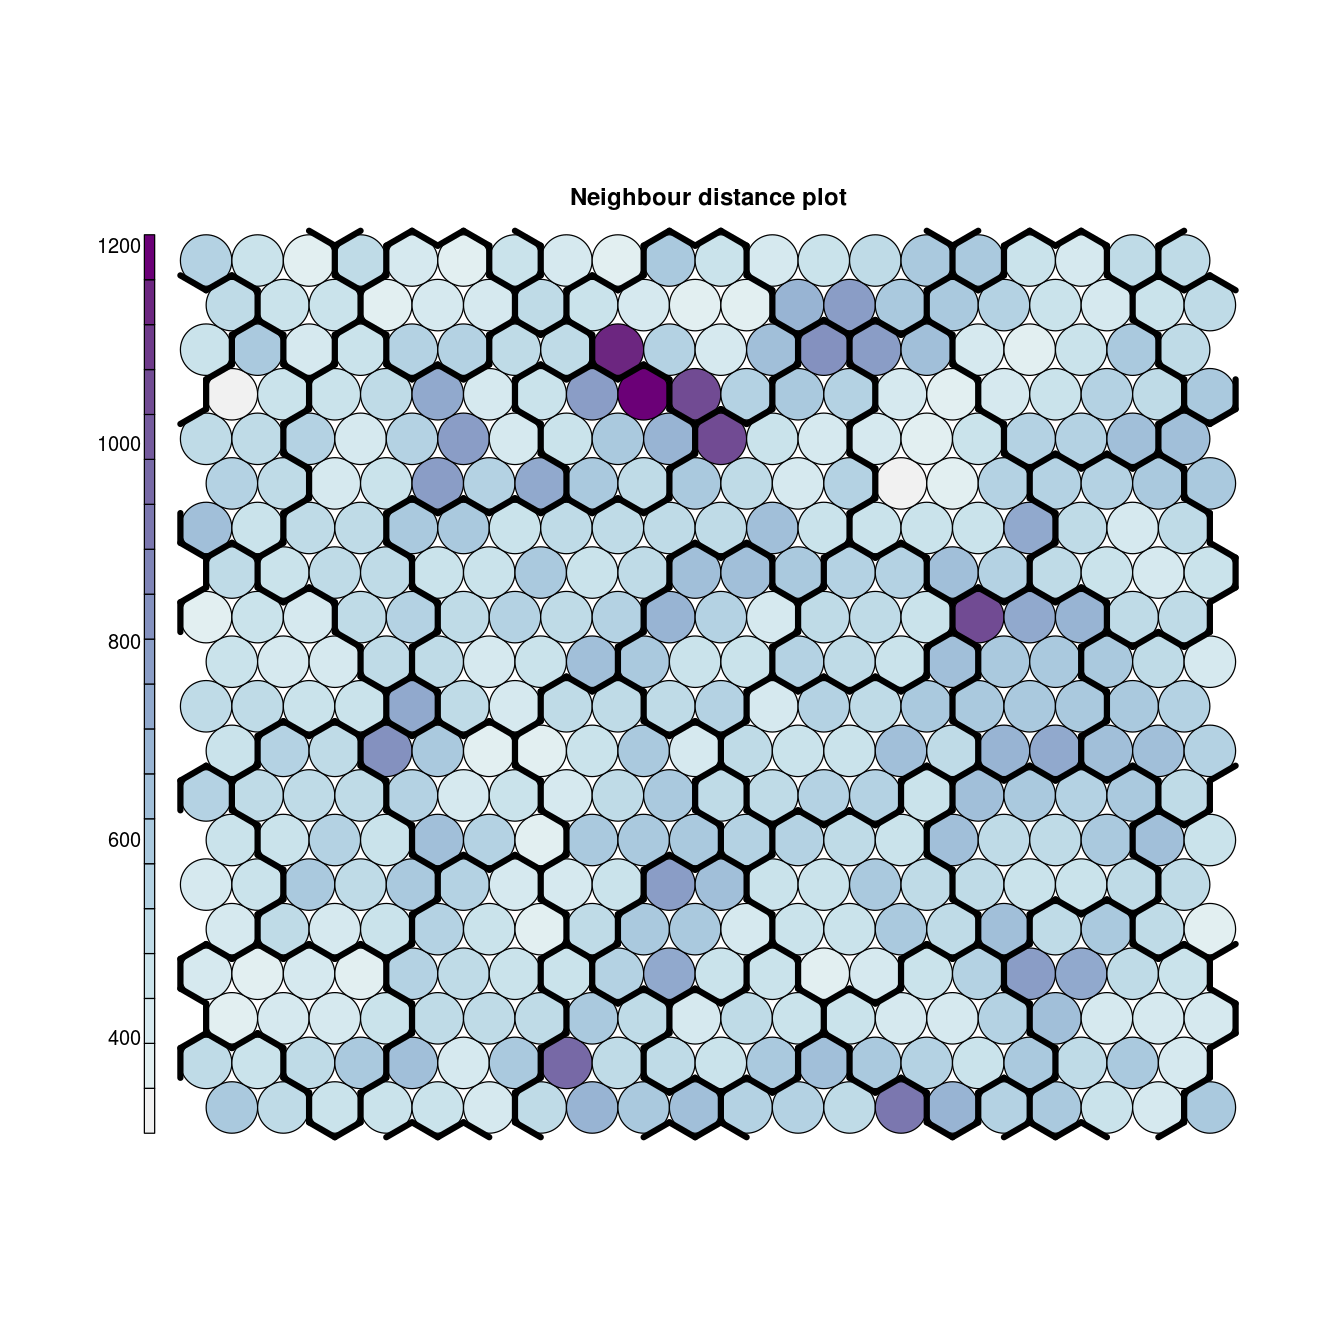

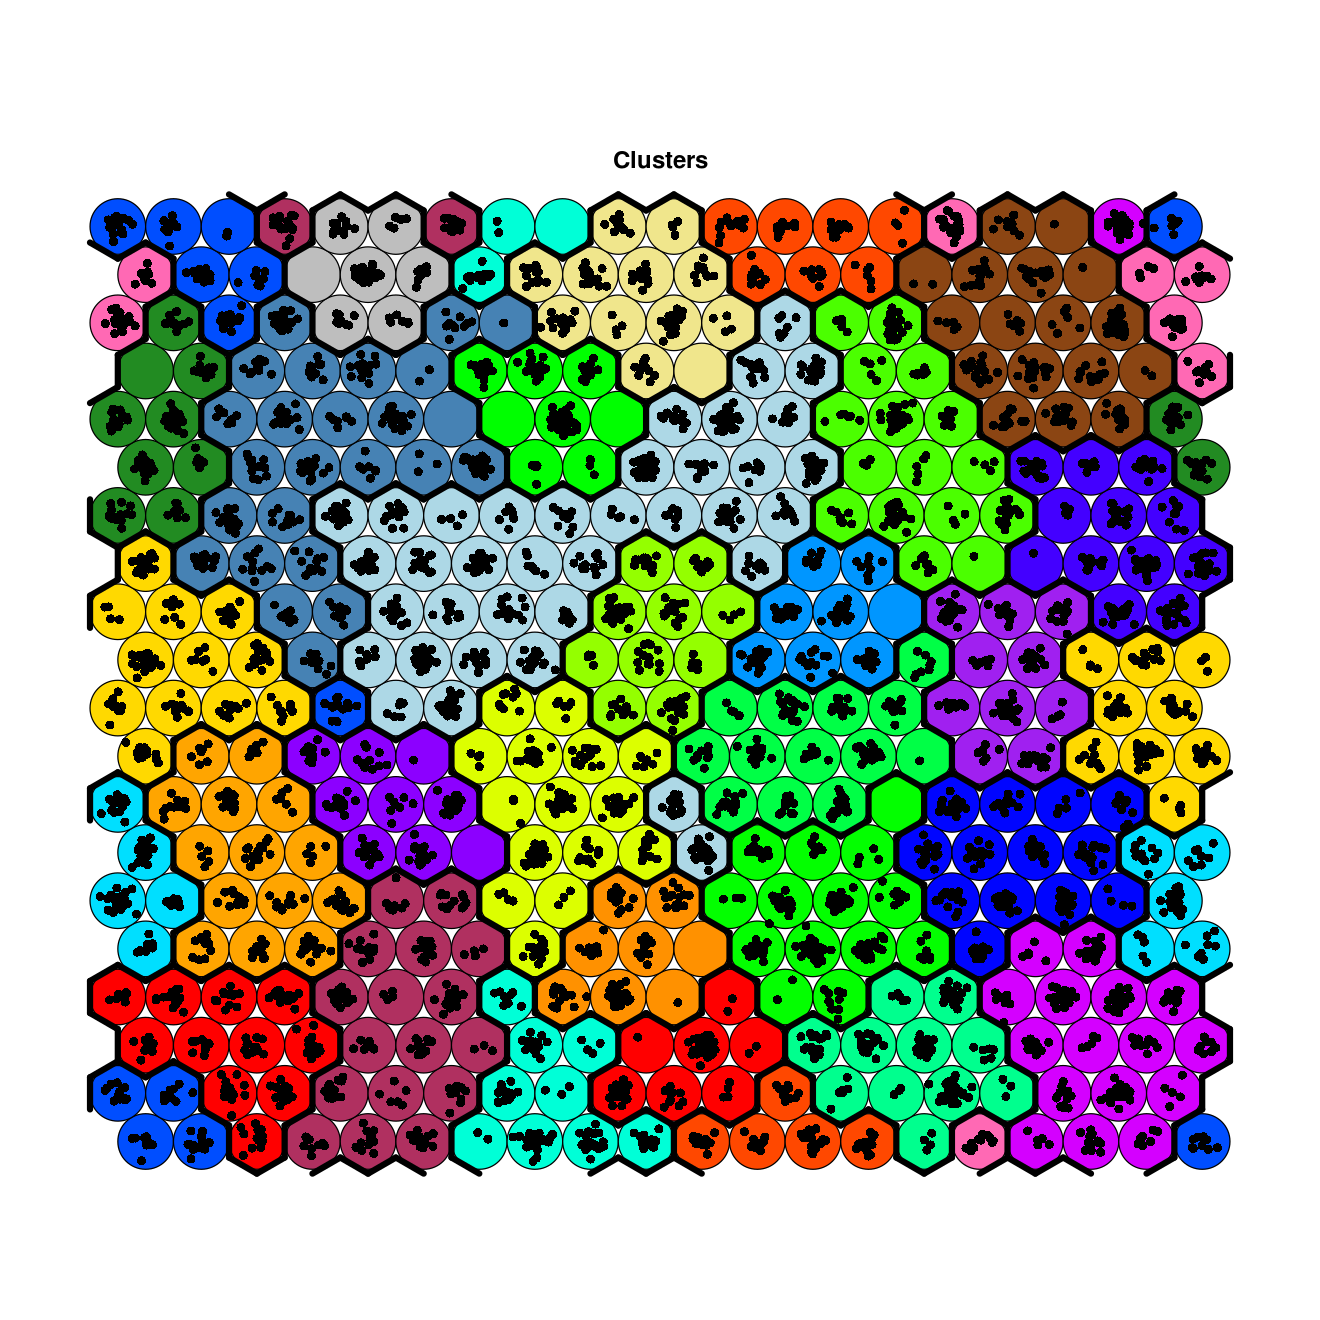

In [122]:
plotSOM = function(clusters)
{
    plot(map, type = 'dist.neighbours', palette.name = colors, pchs = 16)
    add.cluster.boundaries(map, clusters)
}

options(repr.plot.width = 11, repr.plot.height = 11)
plotSOM(clusters)

plot(map, type = "mapping", bgcol = pretty_palette(length(unique(clusters)))[clusters], main = "Clusters", pchs = 16) 
add.cluster.boundaries(map, clusters)

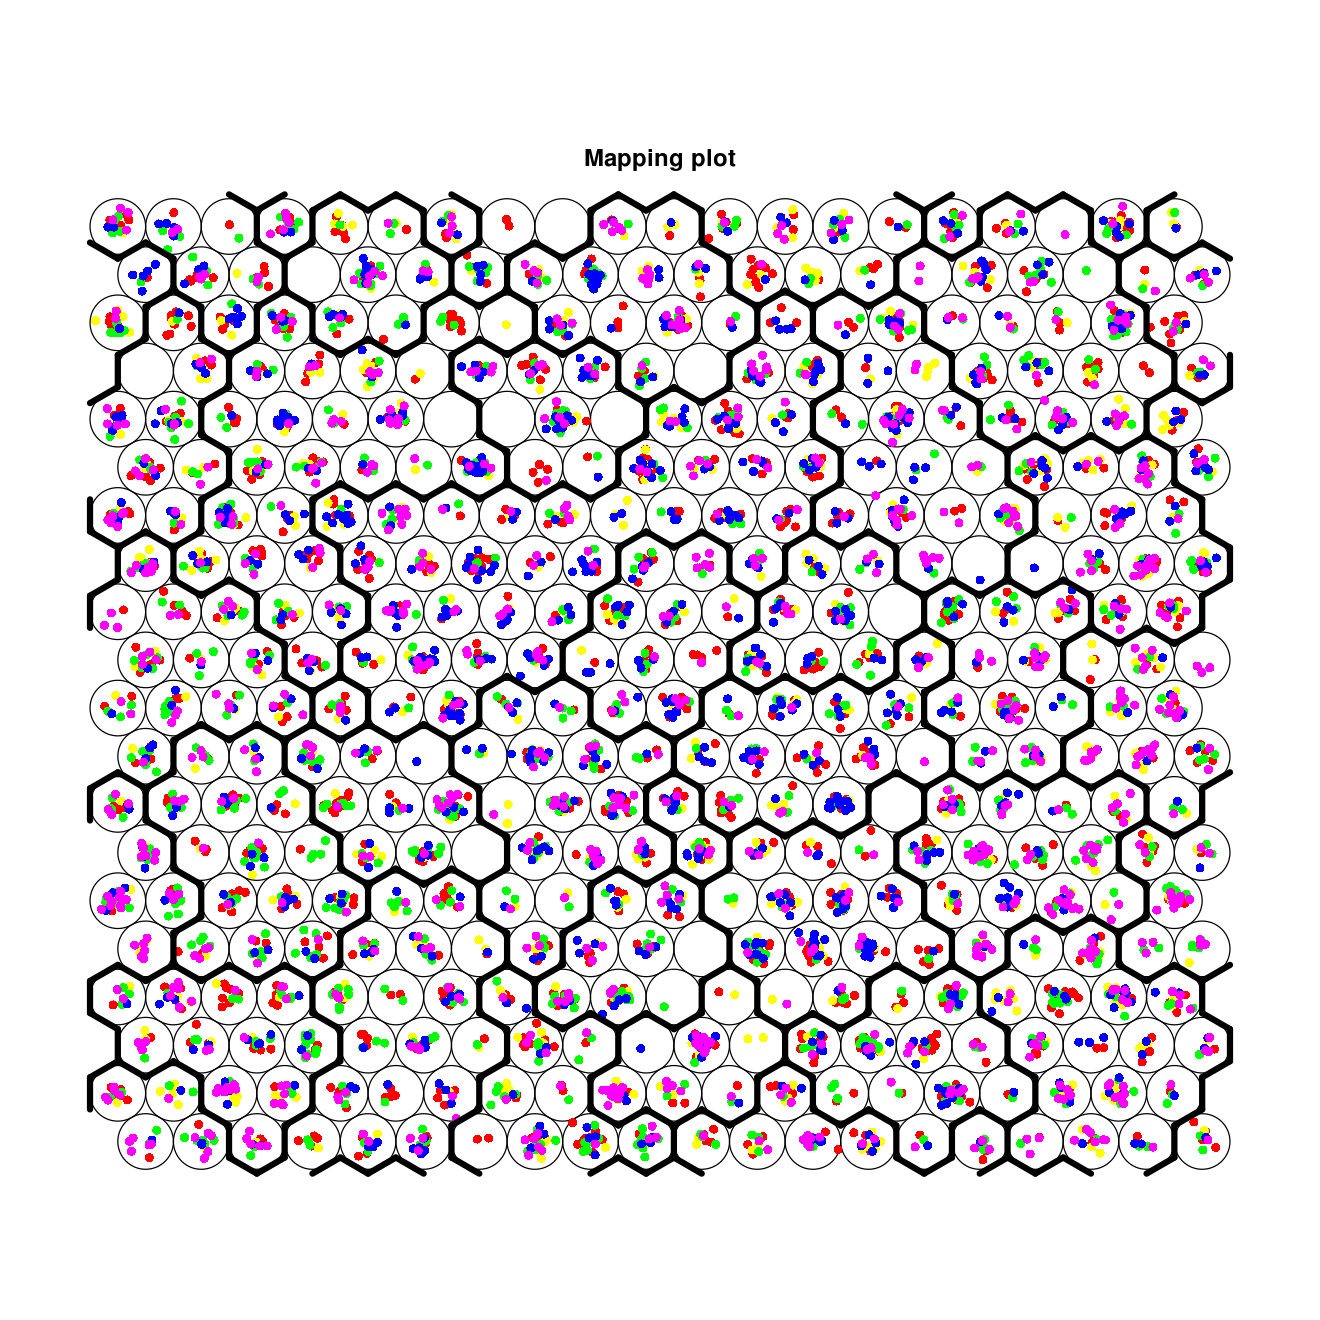

In [123]:
plot(map, type = 'mapping'        , pchs = 16, col = svd_all$color)
add.cluster.boundaries(map, clusters)

In [104]:
str(svd_all)

'data.frame':	4970 obs. of  56 variables:
 $ super_population: chr  "AFR" "AFR" "AFR" "AFR" ...
 $ id              : chr  "HG02111" "HG02541" "HG02537" "HG02586" ...
 $ id_allele       : chr  "HG02111:1" "HG02541:1" "HG02537:1" "HG02586:2" ...
 $ allele          : num  1 1 1 2 1 2 2 1 1 2 ...
 $ v1              : num  -0.0149 -0.0144 -0.0113 -0.0145 -0.0141 ...
 $ v2              : num  -0.02756 -0.0292 -0.00471 -0.00677 -0.01649 ...
 $ v3              : num  -0.000917 0.000956 -0.023897 -0.020674 -0.002546 ...
 $ v4              : num  0.006399 0.006656 0.000566 -0.020297 0.001022 ...
 $ v5              : num  0.01115 0.01052 -0.00938 -0.02274 0.00429 ...
 $ v6              : num  0.001146 0.000265 -0.005648 -0.004529 -0.003645 ...
 $ v7              : num  0.02281 0.02155 -0.00136 0.01089 0.00362 ...
 $ v8              : num  -0.003984 0.002162 -0.001837 -0.006571 0.000816 ...
 $ v9              : num  -0.01398 -0.01879 0.00294 0.00233 0.00604 ...
 $ v10             : num  -0.01511 -

In [103]:
table(svd_data[,c("super_population", "cluster")])

pop2cluster           = as.data.frame.matrix(table(svd_data[,c("population"      , "cluster")]))
colnames(pop2cluster) = paste0("c", 1:ncol(pop2cluster))
pop2cluster           = merge(pops[, c("population_code", "super_population", "population_description")], pop2cluster, by.x = "population_code", by.y = "row.names") %>% arrange(super_population, population_code)
pop2cluster

                cluster
super_population    1    2    3    4    5
             AFR 1015    1   40   39  227
             AMR  135   28  166  221  130
             EAS   40  210  500  160   96
             EUR  123   59  495  186  139
             SAS   88  150  520   87  115

population_code super_population
1  ACB             AFR             
2  ASW             AFR             
3  ESN             AFR             
4  GWD             AFR             
5  LWK             AFR             
6  MSL             AFR             
7  YRI             AFR             
8  CLM             AMR             
9  MXL             AMR             
10 PEL             AMR             
11 PUR             AMR             
12 CDX             EAS             
13 CHB             EAS             
14 CHS             EAS             
15 JPT             EAS             
16 KHV             EAS             
17 CEU             EUR             
18 FIN             EUR             
19 GBR             EUR             
20 IBS             EUR             
21 TSI             EUR             
22 BEB             SAS             
23 GIH             SAS             
24 ITU             SAS             
25 PJL             SAS             
26 STU             SAS             
   population_description                                     c1  c2 c3  c4 c5
1  African Caribbean in Barbados                              152  0  10  6 24
2  African Ancestry in Southwest US                            76  1  16 12 17
3  Esan in Nigeria                                            182  0   1  1 14
4  Gambian in Western Division, The Gambia                    155  0   4 10 57
5  Luhya in Webuye, Kenya                                     148  0   7  3 40
6  Mende in Sierra Leone                                      126  0   0  5 39
7  Yoruba in Ibadan, Nigeria                                  176  0   2  2 36
8  Colombian in Medellin, Colombia                             47  3  66 50 22
9  Mexican Ancestry in Los Angeles, California                 16  8  24 47 33
10 Peruvian in Lima, Peru                                      11  6  20 82 37
11 Puerto Rican in Puerto Rico                                 61 11  56 42 38
12 Chinese Dai in Xishuangbanna, China                          2 69  87 14 14
13 Han Chinese in Bejing, China                                15 39  88 37 27
14 Southern Han Chinese, China                                  5 50 105 21 27
15 Japanese in Tokyo, Japan                                    12  9 101 74 12
16 Kinh in Ho Chi Minh City, Vietnam                            6 43 119 14 16
17 Utah residents with Northern and Western European ancestry  20 14 105 50  9
18 Finnish in Finland                                           8  7 113 53 13
19 British in England and Scotland                             18 18  86 41 19
20 Iberian populations in Spain                                48 11  90 21 44
21 Toscani in Italy                                            29  9 101 21 54
22 Bengali in Bangladesh                                       19 41  93 11  8
23 Gujarati Indian in Houston,TX                               18 27 109 16 36
24 Indian Telugu in the UK                                     16 24 123 24 17
25 Punjabi in Lahore,Pakistan                                  11 29  83 12 43
26 Sri Lankan Tamil in the UK                                  24 29 112 24 11

In [80]:
str(x)

List of 9
 $ cluster     : int [1:4970] 1 1 1 1 1 1 1 1 1 1 ...
 $ centers     : num [1:5, 1:50] -0.0137 -0.0144 -0.0137 -0.015 -0.0146 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:5] "1" "2" "3" "4" ...
  .. ..$ : chr [1:50] "v1" "v2" "v3" "v4" ...
 $ totss       : num 49
 $ withinss    : num [1:5] 12.82 3.76 16.95 6.22 6.22
 $ tot.withinss: num 46
 $ betweenss   : num 3.03
 $ size        : int [1:5] 1401 448 1721 693 707
 $ iter        : int 5
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [77]:
str(svd_all)

'data.frame':	4970 obs. of  56 variables:
 $ super_population: chr  "AFR" "AFR" "AFR" "AFR" ...
 $ id              : chr  "HG02111" "HG02541" "HG02537" "HG02586" ...
 $ id_allele       : chr  "HG02111:1" "HG02541:1" "HG02537:1" "HG02586:2" ...
 $ allele          : num  1 1 1 2 1 2 2 1 1 2 ...
 $ v1              : num  -0.0149 -0.0144 -0.0113 -0.0145 -0.0141 ...
 $ v2              : num  -0.02756 -0.0292 -0.00471 -0.00677 -0.01649 ...
 $ v3              : num  -0.000917 0.000956 -0.023897 -0.020674 -0.002546 ...
 $ v4              : num  0.006399 0.006656 0.000566 -0.020297 0.001022 ...
 $ v5              : num  0.01115 0.01052 -0.00938 -0.02274 0.00429 ...
 $ v6              : num  0.001146 0.000265 -0.005648 -0.004529 -0.003645 ...
 $ v7              : num  0.02281 0.02155 -0.00136 0.01089 0.00362 ...
 $ v8              : num  -0.003984 0.002162 -0.001837 -0.006571 0.000816 ...
 $ v9              : num  -0.01398 -0.01879 0.00294 0.00233 0.00604 ...
 $ v10             : num  -0.01511 -

# OLD - 100kb regions

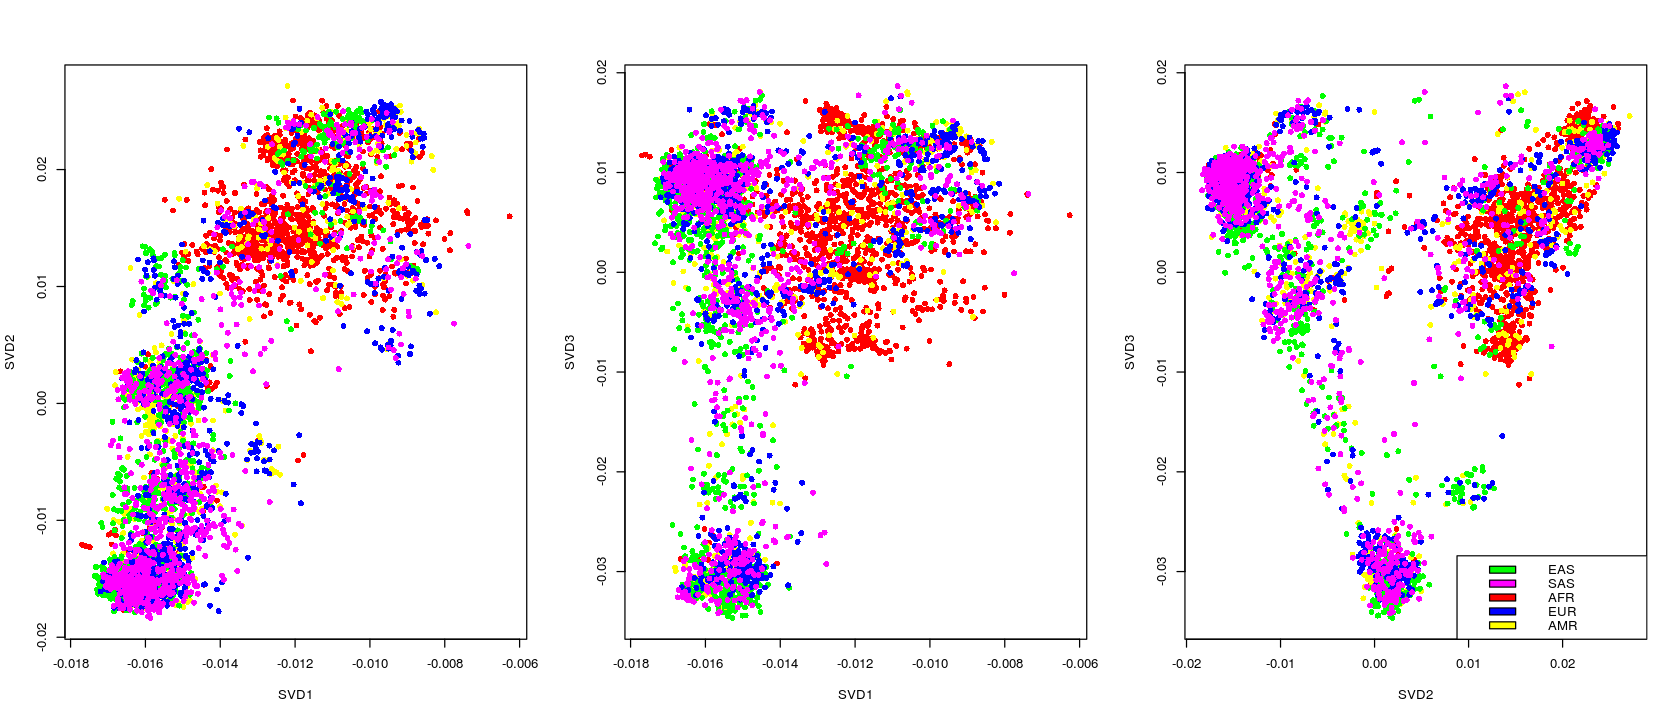

In [46]:
run_svd_irlba = function(x, subject_ids, ancestry_1kgp, superpops)
{
    x = x[, subject_ids$id_allele]
    
    set.seed(1)

    t_comp              = 50
    svd_out             = svd(scale(x, center = colMeans(x), scale = FALSE), nv = t_comp)
    rotations           = svd_out$v
    colnames(rotations) = paste0("v", 1:ncol(rotations))
    out                 = cbind(subject_ids, rotations)
    out                 = merge(out, ancestry_1kgp[, c("subject_id", "population", "super_population")], by.x = "id", by.y = "subject_id")
    out                 = merge(out, superpops    [, c("super_population", "color")])
    
    plot(out$v1, out$v2, pch = 16, col = out$color, xlab = "SVD1", ylab = "SVD2")
    plot(out$v1, out$v3, pch = 16, col = out$color, xlab = "SVD1", ylab = "SVD3")
    plot(out$v2, out$v3, pch = 16, col = out$color, xlab = "SVD2", ylab = "SVD3")
    
    legend("bottomright", legend = superpops$super_population, fill = superpops$color)
    
    return(out)
}

psize(14,6)
layout(rbind(1:3))
a = run_svd_irlba(gts, subject_ids, ancestry_1kgp, superpops)


In [42]:
str(ancestry_1kgp)
a

'data.frame':	2504 obs. of  4 variables:
 $ subject_id      : chr  "HG00096" "HG00097" "HG00099" "HG00100" ...
 $ population      : chr  "GBR" "GBR" "GBR" "GBR" ...
 $ super_population: chr  "EUR" "EUR" "EUR" "EUR" ...
 $ sex             : chr  "male" "female" "female" "female" ...


id      id_allele allele v1         v2           v3           
1   HG00097 HG00097:2 2      0.07093861 -0.013413615 -1.363055e-01
2   HG00105 HG00105:1 1      0.04751465  0.108362675  2.639346e-02
3   HG00110 HG00110:2 2      0.07000291 -0.007992446 -1.112703e-01
4   HG00120 HG00120:1 1      0.06932558 -0.022786403 -1.370736e-01
5   HG00142 HG00142:2 2      0.06556877  0.054607559 -1.038014e-02
6   HG00173 HG00173:2 2      0.07119068 -0.054402639  5.941663e-02
7   HG00174 HG00174:1 1      0.04304226  0.109660792  5.512847e-02
8   HG00188 HG00188:1 1      0.07079855 -0.063294286  4.760454e-02
9   HG00232 HG00232:2 2      0.07437213 -0.063884500  4.039755e-02
10  HG00243 HG00243:2 2      0.07278667 -0.069265858  7.218055e-02
11  HG00244 HG00244:2 2      0.04160223  0.019366400  1.085793e-05
12  HG00264 HG00264:2 2      0.06877254 -0.008707887 -1.404206e-01
13  HG00268 HG00268:1 1      0.06657311 -0.016540448 -1.507632e-01
14  HG00268 HG00268:2 2      0.04952655  0.084853398  1.878011e-02
15  HG00269 HG00269:1 1      0.04431022  0.110385310  1.871740e-02
16  HG00272 HG00272:2 2      0.04162261  0.054569277  6.238427e-03
17  HG00274 HG00274:1 1      0.06953262 -0.054028283  2.965913e-02
18  HG00281 HG00281:1 1      0.06575171 -0.008943947 -1.187204e-01
19  HG00288 HG00288:2 2      0.07257879 -0.066336938  3.611997e-02
20  HG00304 HG00304:2 2      0.07206609 -0.068054584  6.384636e-02
21  HG00315 HG00315:2 2      0.06969985 -0.021529766  6.657097e-02
22  HG00324 HG00324:1 1      0.06854295 -0.020262440 -1.343080e-01
23  HG00326 HG00326:1 1      0.07103160 -0.068768509  7.133487e-02
24  HG00342 HG00342:2 2      0.07290862  0.035725115 -1.764107e-02
25  HG00365 HG00365:1 1      0.07300780 -0.069180801  7.327674e-02
26  HG00367 HG00367:2 2      0.07552265 -0.068939825  6.105296e-02
27  HG00422 HG00422:2 2      0.07082055 -0.063436107  4.585505e-02
28  HG00442 HG00442:2 2      0.07182060 -0.072552027  2.213836e-02
29  HG00557 HG00557:1 1      0.06981707 -0.067062859  4.350692e-02
30  HG00583 HG00583:1 1      0.06870115 -0.061417242  4.842693e-02
⋮   ⋮       ⋮         ⋮      ⋮          ⋮            ⋮            
221 NA19729 NA19729:2 2      0.06907761 -0.067483553  0.036537743 
222 NA19758 NA19758:1 1      0.06793390 -0.024139681 -0.050115707 
223 NA19773 NA19773:2 2      0.06121784  0.049098920  0.030550092 
224 NA19780 NA19780:1 1      0.06781149 -0.049643179  0.014330244 
225 NA19783 NA19783:2 2      0.06511805  0.043668533 -0.014981141 
226 NA19794 NA19794:1 1      0.06724954 -0.020528773 -0.134600000 
227 NA20282 NA20282:2 2      0.05849894  0.100572253  0.040078355 
228 NA20346 NA20346:2 2      0.05103216  0.048231956  0.025090019 
229 NA20504 NA20504:2 2      0.07177601 -0.065776878  0.045683034 
230 NA20508 NA20508:1 1      0.07263132 -0.072949073  0.075171678 
231 NA20516 NA20516:1 1      0.07403524 -0.070643953  0.068762796 
232 NA20517 NA20517:1 1      0.06657585 -0.055481439 -0.006051352 
233 NA20520 NA20520:2 2      0.06660649 -0.053871317 -0.018947971 
234 NA20536 NA20536:1 1      0.05831683 -0.027289180  0.004727442 
235 NA20539 NA20539:2 2      0.04808145  0.103463240  0.036344910 
236 NA20542 NA20542:2 2      0.06717660 -0.003100314 -0.142189956 
237 NA20800 NA20800:1 1      0.04506172  0.112084190  0.045342692 
238 NA20806 NA20806:1 1      0.06957684 -0.061028667  0.048528605 
239 NA20811 NA20811:1 1      0.05737265  0.084672125  0.025869059 
240 NA20846 NA20846:2 2      0.07125638 -0.014042071 -0.131377429 
241 NA20851 NA20851:1 1      0.05618345  0.093966582  0.051631527 
242 NA20854 NA20854:1 1      0.04712537  0.108200767  0.037093849 
243 NA20863 NA20863:1 1      0.04735756  0.101006009  0.018244521 
244 NA20874 NA20874:2 2      0.07264260 -0.062798661  0.055691111 
245 NA20900 NA20900:2 2      0.07228171 -0.071365644  0.071242718 
246 NA20911 NA20911:2 2      0.06716755 -0.054212343 -0.021542311 
247 NA21087 NA21087:2 2      0.04428052  0.107881963  0.047164768 
248 NA21107 NA21107:1 1      0.06065361  0.04066328

In [ ]:
b = a$v
plot(b[,1], b[,2])

In [ ]:
b

In [27]:
ancestry_1kgp

subject_id population super_population sex   
HG00096 HG00096    GBR        EUR              male  
HG00097 HG00097    GBR        EUR              female
HG00099 HG00099    GBR        EUR              female
HG00100 HG00100    GBR        EUR              female
HG00101 HG00101    GBR        EUR              male  
HG00102 HG00102    GBR        EUR              female
HG00103 HG00103    GBR        EUR              male  
HG00105 HG00105    GBR        EUR              male  
HG00106 HG00106    GBR        EUR              female
HG00107 HG00107    GBR        EUR              male  
HG00108 HG00108    GBR        EUR              male  
HG00109 HG00109    GBR        EUR              male  
HG00110 HG00110    GBR        EUR              female
HG00111 HG00111    GBR        EUR              female
HG00112 HG00112    GBR        EUR              male  
HG00113 HG00113    GBR        EUR              male  
HG00114 HG00114    GBR        EUR              male  
HG00115 HG00115    GBR        EUR              male  
HG00116 HG00116    GBR        EUR              male  
HG00117 HG00117    GBR        EUR              male  
HG00118 HG00118    GBR        EUR              female
HG00119 HG00119    GBR        EUR              male  
HG00120 HG00120    GBR        EUR              female
HG00121 HG00121    GBR        EUR              female
HG00122 HG00122    GBR        EUR              female
HG00123 HG00123    GBR        EUR              female
HG00125 HG00125    GBR        EUR              female
HG00126 HG00126    GBR        EUR              male  
HG00127 HG00127    GBR        EUR              female
HG00128 HG00128    GBR        EUR              female
⋮       ⋮          ⋮          ⋮                ⋮     
NA21107 NA21107    GIH        SAS              male  
NA21108 NA21108    GIH        SAS              female
NA21109 NA21109    GIH        SAS              male  
NA21110 NA21110    GIH        SAS              female
NA21111 NA21111    GIH        SAS              male  
NA21112 NA21112    GIH        SAS              male  
NA21113 NA21113    GIH        SAS              male  
NA21114 NA21114    GIH        SAS              male  
NA21115 NA21115    GIH        SAS              male  
NA21116 NA21116    GIH        SAS              male  
NA21117 NA21117    GIH        SAS              male  
NA21118 NA21118    GIH        SAS              male  
NA21119 NA21119    GIH        SAS              male  
NA21120 NA21120    GIH        SAS              female
NA21122 NA21122    GIH        SAS              female
NA21123 NA21123    GIH        SAS              male  
NA21124 NA21124    GIH        SAS              male  
NA21125 NA21125    GIH        SAS              female
NA21126 NA21126    GIH        SAS              male  
NA21127 NA21127    GIH        SAS              male  
NA21128 NA21128    GIH        SAS              male  
NA21129 NA21129    GIH        SAS              male  
NA21130 NA21130    GIH        SAS              male  
NA21133 NA21133    GIH        SAS              male  
NA21135 NA21135    GIH        SAS              male  
NA21137 NA21137    GIH        SAS              female
NA21141 NA21141    GIH        SAS              female
NA21142 NA21142    GIH        SAS              female
NA21143 NA21143    GIH        SAS              female
NA21144 NA21144    GIH        SAS              female

In [16]:
subject_ids

id_allele id      allele
3925 HG01619:2 HG01619 2     
4806 HG01070:2 HG01070 2     
2822 NA19773:2 NA19773 2     
4512 HG00692:2 HG00692 2     
4488 HG04061:2 HG04061 2     
273  NA18998:1 NA18998 1     
3276 NA21087:2 NA21087 2     
3453 NA20542:2 NA20542 2     
690  NA18912:1 NA18912 1     
3659 HG01350:2 HG01350 2     
1985 HG01092:1 HG01092 1     
4576 HG01280:2 HG01280 2     
4914 HG02179:2 HG02179 2     
2419 HG01170:1 HG01170 1     
823  NA19143:1 NA19143 1     
1672 HG03629:1 HG03629 1     
1590 HG03649:1 HG03649 1     
484  NA12716:1 NA12716 1     
683  NA18856:1 NA18856 1     
2598 HG00244:2 HG00244 2     
3945 HG02108:2 HG02108 2     
936  NA11843:1 NA11843 1     
144  NA18640:1 NA18640 1     
2286 HG03120:1 HG03120 1     
2768 NA19054:2 NA19054 2     
1670 HG03019:1 HG03019 1     
3081 NA20911:2 NA20911 2     
2504 NA18548:2 NA18548 2     
4525 HG01853:2 HG01853 2     
2941 NA20346:2 NA20346 2     
⋮    ⋮         ⋮       ⋮     
4347 HG02505:2 HG02505 2     
1731 HG02573:1 HG02573 1     
830  NA19456:1 NA19456 1     
1805 HG00557:1 HG00557 1     
258  HG00365:1 HG00365 1     
3823 HG02968:2 HG02968 2     
2003 HG04061:1 HG04061 1     
349  NA19794:1 NA19794 1     
1069 HG03846:1 HG03846 1     
660  NA21109:1 NA21109 1     
1268 HG01497:1 HG01497 1     
4908 HG02155:2 HG02155 2     
2159 HG01695:1 HG01695 1     
428  NA19213:1 NA19213 1     
4440 HG02696:2 HG02696 2     
3320 NA19466:2 NA19466 2     
1062 HG03066:1 HG03066 1     
1311 HG03168:1 HG03168 1     
2597 HG00243:2 HG00243 2     
158  NA20811:1 NA20811 1     
539  NA12813:1 NA12813 1     
3205 NA21130:2 NA21130 2     
2057 HG01872:1 HG01872 1     
4639 HG02138:2 HG02138 2     
1116 HG02053:1 HG02053 1     
4527 HG01857:2 HG01857 2     
1899 HG03998:1 HG03998 1     
2283 HG03115:1 HG03115 1     
2745 HG00367:2 HG00367 2     
3763 HG02230:2 HG02230 2